# **COVID-19 Data Analysis & Visualization**
![Image](https://www.furman.edu/covid-19/wp-content/uploads/sites/177/2020/03/CoronaVirusHeader-Final-3.jpg)


**Content:**
1. [Load Libraries and Data](#1)
2. [Confirmed Cases Worldwide](#2)
3. [Worldwide Daily Cases and Deaths](#3)
4. [Growth Rate](#4)
5. [World Map: Confirmed Cases and Fatalities Growth](#5)
6. [Trend of COVID-19 in Top 20 Affected Countries](#6)
7. [Mortality Rate](#7)
 * [20 Countries with the Highest Mortality Rate](#8)
 * [20 Countries with the Lowest Mortality Rate](#9)
 * [Mortality Rate Trend of COVID-19 in Top 20 Affected Countries](#22)
8. [COVID-19 in Turkey](#10)
 * [Healing Rate](#11)
 * [Mortality Rate](#24)
9. [Demographic Data of the Countries and the Covid-19 Pandemic](#12)
 *  [Cleaning Data](#13)
 *  [Correlation Map](#14)
10. [Data Analysis of Confirmed Cases in the State of Ontario](#16)
 *  [Gender Distribution of Cases](#17)
 *  [Age Groups Distribution of Cases](#18)
 *  [Age-Gender Distribution of Cases](#19)
 *  [Coronavirus Acquisition-Related Information](#20)
11. [Final](#21)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install pycountry_convert

<a id = "1"></a><br>
**Load Libraries and Data**

In [ ]:
import json
# datetime oprations
from datetime import timedelta
# to get web contents
from urllib.request import urlopen
# basic visualization package
import matplotlib.pyplot as plt
# advanced ploting
import seaborn as sns
 
import datetime as dt
import requests
import sys

# plotly
from plotly import tools, subplots
import pycountry
import pycountry_convert as pc

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "plotly_dark"
%matplotlib inline

# for offline ploting
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('/kaggle/input/novel-corona-virus-2019-dataset/covid_19_data.csv')

In [ ]:
df.head()

In [ ]:
#verileri düzeltme
df.rename(columns={'ObservationDate':'Date','Province/State':'Province_State',
                   'Country/Region':'Country_Region','Confirmed':'ConfirmedCases',
                   'Deaths':'Fatalities'},inplace=True)
df.loc[df['Country_Region']=='Mainland China','Country_Region']='China'
df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
df['Day'] = df.Date.dt.dayofyear
df['cases_lag'] = df.groupby(['Country_Region','Province_State'])['ConfirmedCases'].shift(1) #önceki günün vaka sayısı
df['deaths_lag'] = df.groupby(['Country_Region','Province_State'])['Fatalities'].shift(1) #önceki günün ölüm sayısı
df['Daily Cases'] = df['ConfirmedCases'] - df['cases_lag']  
df['Daily Deaths'] = df['Fatalities'] - df['deaths_lag']         

<a id = "2"></a><br>
# **Confirmed Cases Worldwide**

In [ ]:
class country_utils():
    def __init__(self):
        self.d = {}
    
    def get_dic(self):
        return self.d
    
    def get_country_details(self,country):
        """Returns country code(alpha_3) and continent"""
        try:
            country_obj = pycountry.countries.get(name=country)
            if country_obj is None:
                c = pycountry.countries.search_fuzzy(country)
                country_obj = c[0]
            continent_code = pc.country_alpha2_to_continent_code(country_obj.alpha_2)
            continent = pc.convert_continent_code_to_continent_name(continent_code)
            return country_obj.alpha_3, continent
        except:
            if 'Congo' in country:
                country = 'Congo'
            elif country == 'Diamond Princess' or country == 'Laos' or country == 'MS Zaandam'\
            or country == 'Holy See' or country == 'Timor-Leste':
                return country, country
            elif country == 'Korea, South' or country == 'South Korea':
                country = 'Korea, Republic of'
            elif country == 'Taiwan*':
                country = 'Taiwan'
            elif country == 'Burma':
                country = 'Myanmar'
            elif country == 'West Bank and Gaza':
                country = 'Gaza'
            else:
                return country, country
            country_obj = pycountry.countries.search_fuzzy(country)
            continent_code = pc.country_alpha2_to_continent_code(country_obj[0].alpha_2)
            continent = pc.convert_continent_code_to_continent_name(continent_code)
            return country_obj[0].alpha_3, continent
    
    def get_iso3(self, country):
        return self.d[country]['code']
    
    def get_continent(self,country):
        return self.d[country]['continent']
    
    def add_values(self,country):
        self.d[country] = {}
        self.d[country]['code'],self.d[country]['continent'] = self.get_country_details(country)
    
    def iso3(self,country):
        if country in self.d.keys():
            return self.get_iso3(country)
        else:
            self.add_values(country)
            return self.get_iso3(country)
        
    def fetch_continent(self,country):
        if country in self.d.keys():
            return self.get_continent(country)
        else:
            self.add_values(country)
            return self.get_continent(country)

In [ ]:
df.ConfirmedCases = np.abs(df.ConfirmedCases) #negatif bir değer varsa onu düzeltiyoruz
df1 = df.copy() #veri setini kopyalıyoruz
date = df1.Date.max() #en güncel tarihi alıyoruz
df1 = df1[df1['Date']==date]
obj = country_utils()
df1.Province_State.fillna('',inplace=True) #NA,NaN değerlerini boşlukla dolduruyoruz
df1['continent'] = df1.apply(lambda x: obj.fetch_continent(x['Country_Region']), axis=1) #ülkeleri kıtalara ayırıyoruz
df1["world"] = "World" # hepsini kapsayan tek bir kök düğüm
fig = px.treemap(df1, path=['world', 'continent', 'Country_Region'], values='ConfirmedCases',
                  color='ConfirmedCases', hover_data=['Country_Region'],
                  color_continuous_scale='BuPu', title='COVID 19 Vakalarının Dünya Çapında Dağılımı')
fig.update_layout(width=750,template='seaborn')
fig.show()

In [ ]:
dfContinentt = df1.groupby(['continent'], as_index=False)['ConfirmedCases','Fatalities','Recovered'].sum()
dfContinentt['Recovered'][9] = 23248183.0
dfContinentt['Recovered'][3] = 23739725.0
dfContinentt['ActiveCases'] = dfContinentt['ConfirmedCases']-dfContinentt['Fatalities']-dfContinentt['Recovered']
dfContinentt.index = dfContinentt.index.set_names(['continent'])
dfContinentt = dfContinentt.reset_index(drop=True)
dfContinentt = dfContinentt.melt(id_vars=['continent','ConfirmedCases'],var_name= 'kind', value_name='Cases')

In [ ]:
dfContinentt = dfContinentt[dfContinentt.continent != 'Macau' ]
dfContinentt = dfContinentt[dfContinentt.continent != 'Holy See']
dfContinentt = dfContinentt[dfContinentt.continent != 'Ivory Coast']
dfContinentt = dfContinentt[dfContinentt.continent != 'Timor-Leste']
dfContinentt = dfContinentt[dfContinentt.continent != 'MS Zaandam' ]
dfContinentt = dfContinentt[dfContinentt.continent != 'Diamond Princess']
dfContinentt = dfContinentt[dfContinentt.continent != 'Laos']

In [ ]:
dfContinentt

In [ ]:
fig = px.sunburst(dfContinentt, path=['continent','ConfirmedCases','kind'], values='Cases',title='Continents - Total Cases, Fatalities - Active Cases - Recovered,',color='Cases', color_continuous_scale='amp')
fig.update_layout(width=780,height=750, template='plotly')
fig.show()
#range_color=[0,35000000]

In [ ]:
def daily_measures(df): #günlük ölçümler
    df.loc[0,'Daily Cases'] = df.loc[0,'ConfirmedCases']
    df.loc[0,'Daily Deaths'] = df.loc[0,'Fatalities']
    for i in range(1,len(df)):
        df.loc[i,'Daily Cases'] = df.loc[i,'ConfirmedCases'] - df.loc[i-1,'ConfirmedCases']  #Günlük vaka sayılarını bulmak için o günkü toplam vaka sayısından önceki günün onaylanan vaka sayısını çıkarıyoruz.
        df.loc[i,'Daily Deaths'] = df.loc[i,'Fatalities'] - df.loc[i-1,'Fatalities']
    df.loc[0,'Daily Cases'] = 0 #Daha önceki vaka sayısını günlük olarak bilmediğimiz için ilk satırdaki değerleri 0 a eşitliyoruz.
    df.loc[0,'Daily Deaths'] = 0
    return df

In [ ]:
dfWorld = df.copy()
dfWorld = dfWorld.groupby('Date',as_index=False)['ConfirmedCases','Fatalities','Daily Cases','Daily Deaths'].sum() #Dünyadaki tüm vaka sayılarını ve ölümleri tarihe göre (günlük) grupluyoruz.
dfWorld = daily_measures(dfWorld) #dünyadaki günlük vaka sayılarını alıyoruz
dfWorld['Cases:5-Day Moving Average'] = dfWorld['Daily Cases'].rolling(5).mean() #Vaka sayısının 5 günlük hareketli ortalamasını alıyoruz
dfWorld['Deaths:5-Day Moving Average'] = dfWorld['Daily Deaths'].rolling(5).mean() #Ölüm sayısının 5 günlük hareketli ortalamasını alıyoruz

In [ ]:
dfWorld.head(15)

<a id = "3"></a><br>
# **Worldwide Daily Cases and Deaths**

In [ ]:
fig2 = go.Figure(data=[
    go.Bar(name='Vakalar', x=dfWorld['Date'], y=dfWorld['Daily Cases']),
    go.Bar(name='Ölümler', x=dfWorld['Date'], y=dfWorld['Daily Deaths'])
])

In [ ]:
#Hareketli ortalama çizgimizi ekleyiyoruz
fig2.add_trace(go.Scatter(name='Vakalar: 5 Günlük Hareketli Ortalama',x=dfWorld['Date'],y=dfWorld['Cases:5-Day Moving Average'],marker_color='white'))
fig2.add_trace(go.Scatter(name='Ölümler: 5 Günlük Hareketli Ortalama',x=dfWorld['Date'],y=dfWorld['Deaths:5-Day Moving Average'],marker_color='magenta'))
#Grafiği daha okunabilir hale getirme
fig2.update_layout(barmode='overlay', title='Dünya Çapında Günlük Vaka ve Ölüm Sayısı',hovermode='x',
                template='plotly_dark', width=780,xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='aliceblue'),legend=dict(orientation='h',x=0.1,y=-0.2))
fig2.show()

In [ ]:
# Create figure with secondary y-axis
fig5 = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig5.add_trace(go.Scatter(x=dfWorld['Date'], y=dfWorld['Cases:5-Day Moving Average'], name="Vakalar: 5 Günlük Hareketli Ortalama",marker_color='white'), secondary_y=False,)
fig5.add_trace(go.Scatter(x=dfWorld['Date'], y=dfWorld['Deaths:5-Day Moving Average'], name="Ölümler: 5 Günlük Hareketli Ortalama",marker_color='red'), secondary_y=True,)
fig5.update_layout(title_text="Dünya Çapında Günlük Vaka ve Ölüm Sayısının İlerleyişi")
fig5.update_xaxes(title_text="Tarih")
fig5.update_yaxes(title_text="<b>Vakalar</b> ", secondary_y=False)
fig5.update_yaxes(title_text="<b>Ölümler</b> ", secondary_y=True, tickfont=dict(
            color="red" ),titlefont=dict(color="red"))
fig5.update_layout(hovermode='x', width=780, xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='aliceblue'),legend=dict(orientation='h',x=0.1,y=-0.2))
fig5.show()

In [ ]:
dfWorld['Cases:21-Day Moving Average'] = dfWorld['Daily Cases'].rolling(21).mean() #Vaka sayısının 5 günlük hareketli ortalamasını alıyoruz
dfWorld['Deaths:21-Day Moving Average'] = dfWorld['Daily Deaths'].rolling(21).mean() #Ölüm sayısının 5 günlük hareketli ortalamasını alıyoruz

In [ ]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(go.Scatter(x=dfWorld['Date'], y=dfWorld['Cases:21-Day Moving Average'], name="Vakalar: 21 Günlük Hareketli Ortalama",marker_color='white'), secondary_y=False,)
fig.add_trace(go.Scatter(x=dfWorld['Date'], y=dfWorld['Deaths:21-Day Moving Average'], name="Ölümler: 21 Günlük Hareketli Ortalama",marker_color='red'), secondary_y=True,)
fig.update_layout(title_text="Dünya Çapında Günlük Vaka ve Ölüm Sayısının İlerleyişi")
fig.update_xaxes(title_text="Tarih")
fig.update_yaxes(title_text="<b>Vakalar</b> ", secondary_y=False)
fig.update_yaxes(title_text="<b>Ölümler</b> ", secondary_y=True, tickfont=dict(
            color="red" ),titlefont=dict(color="red"))
fig.update_layout(hovermode='x', width=780, xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='aliceblue'),legend=dict(orientation='h',x=0.1,y=-0.2))
fig.show()

In [ ]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Scatter(name='Günlük Vaka Sayısı',x=dfWorld['Date'],y=dfWorld['Daily Cases'] ,marker_color='white'), row=1, col=1)
fig.add_trace(go.Scatter(name='Günlük Ölüm Sayısı',x=dfWorld['Date'],y=dfWorld['Daily Deaths'],marker_color='red'), row=2, col=1)
fig.update_layout(height=710, width=780,
                  title_text="Dünya Çapında Günlük Vaka ve Ölüm Sayıları",hovermode='x unified')
fig.show()

<a id = "4"></a><br>
# **Growth Rate (Büyüme Oranı)**
Büyüme Oranı, o günkü yeni vaka sayısının, önceki günkü yeni vaka sayısına bölünmesiyle hesaplanmaktadır. Büyüme Oranı 1'den fazla olduğunda yeni vaka sayısı artmış, 1'den düşük olduğunda yeni vaka sayısı düşmüş olacaktır.

Aşağıdaki grafikte görüldüğü üzere Dünya'da ki "COVID-19 Büyüme Oranı", Nisan ayından itibaren 1 civarında seyretmektedir. Bu durum Nisan ayından itibaren onaylanan yeni vaka sayılarının, artış göstermediği fakat aynı zamanda azalış da göstermediği anlamına gelmektedir.

In [ ]:
dfWorld['growthFactor'] = dfWorld['Daily Cases'] / dfWorld['Daily Cases'].shift(1)
dfWorld.tail() #Feature Engineering

In [ ]:
fig = px.line(dfWorld, x='Date', y='growthFactor', title='Dünya Çapında COVID-19 Vakalarının Büyüme Oranı')
fig.add_trace(go.Scatter(x=[dfWorld['Date'].min(), dfWorld['Date'].max()], y=[1., 1.], name='Büyüme Oranı=1.', line=dict(dash='dash', color=('rgb(237, 37, 75)'))))
fig.update_layout(hovermode='closest',template='plotly_dark',width=780,xaxis=dict(mirror=True,linewidth=1,linecolor='white', title='Tarih'),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='white', title='Büyüme Katsayısı'))
fig.update_yaxes(range=[0., 7.]) #feb13 growth rate= 36.15
fig.show() 

<a id = "5"></a><br>
# **World Map: Confirmed Cases and Fatalities Growth (Logarithmic Scale)**

In [ ]:
dfWmap = df.copy()
dfWmap['Date']=dfWmap['Date'].astype(str)
dfWmap = dfWmap.groupby(['Date','Country_Region'], as_index=False)['ConfirmedCases','Fatalities'].sum()
dfWmap.head(10)

In [ ]:
dfWmap['iso_alpha'] = dfWmap.apply(lambda x: obj.iso3(x['Country_Region']), axis=1)
dfWmap.head()

In [ ]:
#Veriler çok geniş bir değer aralığında (örn: ABD ve Yeni Zelanda'nın vaka sayısı arasındaki fark) olduğu için logaritmik ölçek kullanıyoruz.
dfWmap['log(ConfirmedCases)'] = np.log(dfWmap.ConfirmedCases + 1)
dfWmap['log(Fatalities)'] = np.log(dfWmap.Fatalities + 1)

In [ ]:
px.choropleth(dfWmap, #Confirmed Cases Growth
              locations="iso_alpha", 
              color="log(ConfirmedCases)", 
              hover_name="Country_Region", 
              hover_data=["ConfirmedCases"] ,
              animation_frame="Date",
              color_continuous_scale=px.colors.sequential.BuPu, 
              title='Logaritmik Ölçekte Ülkelere Göre Onaylanan Vaka Sayısı Büyümesi')

In [ ]:
px.choropleth(dfWmap, #Fatalities Growth
             locations='iso_alpha',
             color='log(Fatalities)',
             hover_name='Country_Region',
             hover_data=["Fatalities"],
             animation_frame="Date",
             color_continuous_scale=px.colors.sequential.amp,
             title='Logaritmik Ölçekte Ülkelere Göre Ölüm Sayısının Gelişimi')

<a id = "6"></a><br>
# **Trend of COVID-19 in Top 20 Affected Countries**

In [ ]:
last_date = df.Date.max() #en güncel toplam vaka saysını alabilmek için en güncel tarihi alıyoruz
dfCountries = df[df['Date']==last_date]
dfCountries = dfCountries.groupby('Country_Region', as_index=False)['ConfirmedCases','Fatalities'].sum()
dfCountries = dfCountries.nlargest(20,'ConfirmedCases') #En çok vaka sayısı olan 20 ülkeyi alıyoruz
#En çok etkilenen 20 ülkenin trendi
df_trend = df.groupby(['Date','Country_Region'], as_index=False)['ConfirmedCases','Fatalities'].sum()
df_trend = df_trend.merge(dfCountries, on='Country_Region')
df_trend.drop(['ConfirmedCases_y','Fatalities_y'],axis=1, inplace=True)
df_trend.rename(columns={'Country_Region':'Country', 'ConfirmedCases_x':'Cases', 'Fatalities_x':'Deaths'}, inplace=True)

In [ ]:
fig = px.line(df_trend, x='Date', y='Cases', color='Country', title='En Çok Etkilnenen 20 Ülkenin COVID-19 Vaka Sayısı Gelişimi')
fig.update_layout(hovermode='closest',template='plotly_dark',width=750,xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False, title='Tarih'),
                 yaxis=dict(mirror=True,linewidth=2,linecolor='white', title='Vaka Sayısı'))
fig.show() #total confirmed cases growth

In [ ]:
fig = px.line(df_trend, x='Date', y='Deaths', color='Country', title='En Çok Etkilnenen 20 Ülkenin COVID-19 Ölüm Sayısı Gelişimi')
fig.update_layout(hovermode='closest',template='plotly_dark',width=750,xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False, title='Tarih'),
                 yaxis=dict(mirror=True,linewidth=2,linecolor='white',title='Ölüm Sayısı'))
fig.show() #total deaths growth

<a id = "7"></a><br>
# **Mortality Rate (Ölüm Oranı)**
Toplam ölüm sayılarının, onaylanan vaka sayılarına bölünmesiyle hesaplanmaktadır.

In [ ]:
dfWmap['MortalityRate%'] = round((dfWmap.Fatalities/dfWmap.ConfirmedCases)*100,3)
dfWmap.tail()

In [ ]:
px.choropleth(dfWmap, 
                    locations="iso_alpha", 
                    color="MortalityRate%", 
                    hover_name="Country_Region",
                    hover_data=["ConfirmedCases","Fatalities"],
                    animation_frame="Date",
                    color_continuous_scale=px.colors.sequential.OrRd,
                    title = 'Dünyada Günlük Ölüm Oranlarının Değişimi')

In [ ]:
last_date = df.Date.max()
dfMor= df[df['Date']==last_date]
dfMor=dfMor.groupby(['Country_Region'], as_index=False)['Country_Region','ConfirmedCases','Fatalities'].sum()
dfMor['MortalityRate%'] = round((dfMor.Fatalities/dfMor.ConfirmedCases)*100,3)
dfMorMax = dfMor.nlargest(20,'MortalityRate%')
dfMorMax

<a id = "8"></a><br>
**20 Countries with the Highest Mortality Rate**

In [ ]:
fig = px.bar(dfMorMax[:20].iloc[::-1],
            x='MortalityRate%',
            y='Country_Region',
            title="Ölüm Oranı En Yüksek 20 Ülke (20 Countries with the Highest Mortality Rate)",
            text='MortalityRate%',
            labels={
                     "MortalityRate%": "Ölüm Oranı %",
                     "Country_Region": "Ülkeler" },
            height=750,
            orientation='h')
fig.show()

<a id = "9"></a><br>
**20 Countries with the Lowest Mortality Rate**

In [ ]:
dfMorMin = dfMor.nsmallest(20,'MortalityRate%')
fig = px.bar(dfMorMin[:20].iloc[::-1],
            x='MortalityRate%',
            y='Country_Region',
            title="Ölüm Oranı En Düşük 20 Ülke (20 Countries with the Lowest Mortality Rate)",
            text='MortalityRate%',
              labels={
                     "MortalityRate%": "Ölüm Oranı %",
                     "Country_Region": "Ülkeler" },
            height=750,
            orientation='h')
fig.show()

In [ ]:
dfMorMin

In [ ]:
df_trend['MortalityRate%'] = round((df_trend.Deaths/df_trend.Cases)*100,1)

<a id = "22"></a><br>
**Mortality Rate Trend of COVID-19 in Top 20 Affected Countries**

In [ ]:
fig = px.line(df_trend, x='Date', y='MortalityRate%', color='Country', title='COVID-19 dan En Çok Etkilenen 20 Ülkenin Ölüm Oranı Değişimleri')
fig.update_layout(hovermode='closest',template='plotly_dark',xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False, title='Tarih'),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='white', title='Ölüm Oranı%'))
fig.show()

<a id = "10"></a><br>
# **COVID-19 in TURKEY**

In [ ]:
dfTr = df[df['Country_Region']=='Turkey']
dfTr.tail()

In [ ]:
dfTR = dfTr.groupby(['Date'], as_index=False)['ConfirmedCases','Fatalities','Recovered'].sum()

In [ ]:
melt_df_tr = pd.melt(dfTR, id_vars=['Date'], value_vars=['ConfirmedCases', 'Fatalities', 'Recovered'])
melt_df_tr

In [ ]:
fig = px.line(melt_df_tr, x="Date", y="value", color='variable',
              labels={  "Date": "Tarih",
                        "value": "Değer",
                        "variable": ""}, 
              title="Türkiye'de Onaylanan Vakalarının, Ölümlerin ve İyileşen Hastaların İlerleyişi")
fig.show()

In [ ]:
dfTR['casesPrev'] = dfTR['ConfirmedCases'].shift(1)
dfTR['casesDaily']= dfTR['ConfirmedCases'] - dfTR['casesPrev'] #günlük vaka sayısı
dfTR.tail()

In [ ]:
dfTR['deathsDaily']= dfTR['Fatalities'] - dfTR['Fatalities'].shift(1) #günlük ölüm sayısı

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=dfTR['Date'], y=dfTR['casesDaily'],
                    mode='lines+markers',
                    name='Günlük Vaka Sayıları'), secondary_y=False,)

fig.add_trace(go.Scatter(x=dfTR['Date'], y=dfTR['deathsDaily'],
                    mode='lines+markers',
                    name='Günlük Ölüm Sayıları'), secondary_y=True,)

fig.update_layout( title="Türkiye'de Günlük Vaka ve Ölüm Sayısı",hovermode='x',
                template='plotly_dark',xaxis=dict(mirror=True,linewidth=1,linecolor='aliceblue',showgrid=False),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='aliceblue'),legend=dict(orientation='h',x=0.2,y=-0.2))

fig.update_xaxes(title_text="Tarih")
fig.update_yaxes(title_text="<b>Vakalar</b> ", secondary_y=False)
fig.update_yaxes(title_text="<b>Ölümler</b> ", secondary_y=True) 

fig.show()

In [ ]:
dfTR['growthRate'] = dfTR['casesDaily'] / dfTR['casesDaily'].shift(1)
fig = px.line(dfTR, x='Date', y='growthRate', title="Türkiye'de COVID-19 Vakalarının Büyüme Oranı")
fig.add_trace(go.Scatter(x=[dfWorld['Date'].min(), dfWorld['Date'].max()], y=[1., 1.], name='Büyüme Oranı=1.', line=dict(dash='dash', color=('rgb(237, 37, 75)'))))
fig.update_layout(hovermode='closest',template='plotly_dark',xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False, title='Tarih'),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='white',title='Büyüme Katsayısı'))
fig.update_yaxes(range=[0., 4.])
fig.show()

<a id = "11"></a><br>
# **Healing Rate (Vakaların İyileşme Oranı)**

Toplam iyileşen hasta sayısının, vaka sayısına bölünmesiyle hesaplanmaktadır.

In [ ]:
dfTR['healingRate%'] = round((dfTR.Recovered/dfTR.ConfirmedCases)*100,1)
dfTR

In [ ]:
fig = px.line(dfTR, x='Date', y='healingRate%', title="Türkiye'de COVID-19 Vakalarının İyileşme Oranı")
fig.update_layout(hovermode='closest',template='plotly_dark',width=750, xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False, title='Tarih'),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='white',title='İyileşme Oranı'))
fig.show()

<a id = "24"></a><br>
**Mortality Rate (Turkey)**

In [ ]:
dfTR['mortalityRate%'] = round((dfTR.Fatalities/dfTR.ConfirmedCases)*100,1)
fig = px.line(dfTR, x='Date', y='mortalityRate%', title="Türkiye'de COVID-19 Vakalarının Ölüm Oranı")
fig.update_layout(hovermode='closest',template='plotly_dark',width=750, xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False, title='Tarih'),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='white', title='Ölüm Oranı%'))
fig.show()

<a id = "12"></a><br>
# **Ülkelerin Demografik Verilerinin Covid-19 Pandemi Süreciyle Olan İlişkisi**
**The Relationship between the Demographic Data of the Countries and the Covid-19 Pandemic**

In [ ]:
population = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv')
population.head()

In [ ]:
pop = population[['Country (or dependency)','Population (2020)', 'Med. Age','Density (P/Km²)']]
pop.columns= ['country','population','avrgAge','density']
pop.head(10)

In [ ]:
pop.loc[pop['country'] == 'United States', "country"] = "US"
pop.loc[pop['country'] == 'Czech Republic (Czechia)', "country"] = 'Czech Republic'
pop.loc[pop['country'] == 'United Kingdom', "country"] = "UK"
pop.head()

In [ ]:
hc1 = pd.read_html('https://www.numbeo.com/health-care/rankings_by_country.jsp')
hc1

In [ ]:
hc = pd.read_html('https://www.numbeo.com/health-care/rankings_by_country.jsp')
hc1 = hc[1]
hc = hc1[['Country', 'Health Care Index']]

In [ ]:
hc.columns= ['country','healthcare_index']
hc.loc[hc['country'] == 'United States', "country"] = "US"
hc.loc[hc['country'] == 'United Kingdom', "country"] = "UK"
hc.tail()

In [ ]:
last_date = df.Date.max()
dfTotal = df[df['Date']==last_date]
dfTotal=dfTotal.groupby(['Country_Region'], as_index=False)['Country_Region','ConfirmedCases','Fatalities','Recovered'].sum()
dfTotal['mortalityRate%'] = round((dfTotal.Fatalities/dfTotal.ConfirmedCases)*100,1)
dfTotal['healingRate%'] = round((dfTotal.Recovered/dfTotal.ConfirmedCases)*100,1)
dfTotal.rename(columns={'Country_Region':'country'},inplace=True)
dfTotal.head()

In [ ]:
dfTotal = pd.merge(dfTotal, pop, on='country', how='left',copy = False) #3 tane veri setini birleştiriyoruz
dfTotal = pd.merge(dfTotal, hc, on='country', how = 'left',copy = False)
dfTotal

<a id = "13"></a><br>
**Cleaning Data (Veri Temizleme)**

In [ ]:
dfTotal.info() #kaç tane null veri var bakalım

In [ ]:
dfTotal[dfTotal["avrgAge"].isnull()] #avrgAge sütunu NaN olan kayıtları listeliyoruz

In [ ]:
dfTotal = dfTotal.dropna(how='any', subset=['population', 'density','avrgAge'])
#population,density,avrgAge,healthcare_index sütunlarındaki verilerin hepsi NaN olduğu için,
#ortalamayla doldurmak yerine bu kayıtları silmeyi tercih ettim

In [ ]:
assert dfTotal["population"].notnull().all() #kontrol ediyoruz

In [ ]:
dfTotal #görüldüğü üzere 12 kayıt silinmiş 178 satır var

In [ ]:
dfTotal['avrgAge'] = dfTotal['avrgAge'].replace('N.A.', '0') #4.satırda görüldüğü üzere avrgAge sütununda N.A şeklinde değerler var
dfTotal['avrgAge'] = dfTotal['avrgAge'].astype('int') #bu değerleri 0'a eşitleyip string tipi int yaptık
dfTotal['avrgAge'] = dfTotal['avrgAge'].replace(0, dfTotal['avrgAge'].mean()) #ve bu kayıp verileri sütun ortalamasıyla doldurduruyoruz
dfTotalNew = dfTotal.copy()
dfTotal['healthcare_index'] = dfTotal['healthcare_index'].replace(np.nan, dfTotal['healthcare_index'].mean())

dfTotal['avrgAge'] = dfTotal['avrgAge'].astype('int')
dfTotal['ConfirmedCases'] = dfTotal['ConfirmedCases'].astype('int')
dfTotal['Fatalities'] = dfTotal['Fatalities'].astype('int')
dfTotal['Recovered'] = dfTotal['Recovered'].astype('int')
dfTotal['population'] = dfTotal['population'].astype('int')
dfTotal['density'] = dfTotal['density'].astype('int') #float tipindeki sütunları int veri tipine dönüştürdük

dfTotal.info()
dfTotal.head()
#verileri temizledik

In [ ]:
dfTotalNew

## **Countries with Highest and Lowest Number of Cases According to Population (total cases per 1,000)**

In [ ]:
dfTotal1 = dfTotal.copy()
dfTotal1['cases/1kpop'] = round((dfTotal.ConfirmedCases/dfTotal.population)*1000,2) #1000 kişi başına düşen toplam vaka sayısı
dfTotal1 #total cases per 1,000

In [ ]:
dfcpMax = dfTotal1.nlargest(25,'cases/1kpop')
#dfcpMax

In [ ]:
fig = px.bar(dfcpMax[:25].iloc[::-1], #Highest
            x='cases/1kpop',
            y='country',
            color_discrete_sequence=['#8949d2'],
            title="Nüfusa Oranla En Yüksek Vaka Sayısına Sahip 25 Ülke / 1000 Kişi Başına Düşen Toplam Vaka Sayısı (total cases per 1,000)",
            text='cases/1kpop',
            labels={
                     "cases/1kpop": "1000 Kişi Başına Düşen Toplam Vaka Sayısı",
                     "country": "Ülkeler" },
            height=870,
            orientation='h')
fig.show()  

In [ ]:
dfcpMin = dfTotal1.nsmallest(20,'cases/1kpop')  #Lowest
fig = px.bar(dfcpMin[:20].iloc[::-1],
            x='cases/1kpop',
            y='country',
            color_discrete_sequence=['#21bf73'],
            title="Nüfusa Oranla En Düşük Vaka Sayısına Sahip 20 Ülke / 1000 Kişi Başına Düşen Toplam Vaka Sayısı (total cases per 1,000)",
            text='cases/1kpop',
              labels={
                     "cases/1kpop": "1000 Kişi Başına Düşen Toplam Vaka Sayısı ",
                     "country": "Ülkeler" },
            height=730,
            orientation='h')
fig.show()

In [ ]:
dfTotalNew

In [ ]:
dfTotal1["healing(per100)"] = np.round((dfTotal1["Recovered"]/dfTotal1["ConfirmedCases"])*100,3)
dfTotal1.head()

### 20 Countries with the Highest Recovery Rate and Healthcare Index

In [ ]:
dfTotalNew = dfTotalNew.dropna(how='any', subset=['healthcare_index'])

In [ ]:
assert dfTotal["healthcare_index"].notnull().all() #kontrol

In [ ]:
dfTotalNew.sort_values('healingRate%', ascending=False)[['country', 'healthcare_index','healingRate%']][:20].style.background_gradient(cmap='Greens')
#Vaka İyileşme Oranı En Yüksek Ülkeler ve Sağlık Hizmeti Endeksleri

### 20 Countries with the Lowest Recovery Rate and Healthcare Index

In [ ]:
dfTotalNew.sort_values('healingRate%', ascending=True)[['country', 'healthcare_index','healingRate%']][7:27].style.background_gradient(cmap='coolwarm_r')

<a id = "14"></a><br>
**Correlation Map (Korelasyon Haritası)**

Özellikler arasındaki ilişkiyi (bağlılığı) renkli tablo şeklinde görüyoruz. Görüldüğü üzere onaylanan vaka sayısı (ConfirmedCases) ve gerçekleşen ölümler (Fatalities) arasında pozitif doğrusal bir ilişki olduğu görülüyor. Aynı şekilde ülke nüfusu (population) ve onaylanan pozitif vakalar (ConfirmedCases) arasında da pozitif doğrusal bir ilişki olduğu söylenebilir.

In [ ]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(dfTotal.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [ ]:
fig = px.scatter(dfTotal, x='population', y='ConfirmedCases', color='mortalityRate%',width=770, height=590, 
                 hover_name='country', log_x=True, log_y=True, title='Population vs Confirmed (Nüfus - Onayalanan Vaka) w/Ölüm Oranı',template='ggplot2', range_color=[0,12])
fig.show()

In [ ]:
fig = px.scatter(dfTotal, x='Recovered', y='Fatalities', color='healthcare_index',width=770, height=590, 
                 hover_name='country', log_x=True, log_y=True, title='Recovered vs Fatalities (İyileşenler - Ölümler) w/Sağlık Hizmeti',template='ggplot2', range_color=[50,85])
fig.show()

In [ ]:
fig = px.scatter(dfTotal, x='healthcare_index', y='avrgAge', color='healingRate%',width=770, height=590,
                 hover_name='country', log_x=True, log_y=True, title='Healthcare Index vs Avrrage Age (Sağlık Hizmeti - Ortalama Yaş) /İyileşme Oranı',template='ggplot2')
fig.show()

In [ ]:
fig = px.scatter(dfTotal, x='ConfirmedCases', y='density', color='healthcare_index',width=770, height=590, 
                 hover_name='country', log_x=True, log_y=True, title='Density(pop./km2) vs Confirmed Casses (Nüfus Yoğunluğu - Onayalanan Vaka)',template='ggplot2')
fig.show()

In [ ]:
fig = px.scatter(dfTotal, x='mortalityRate%', y='Fatalities', color='healthcare_index',width=770, height=590, 
                 hover_name='country', log_x=True, log_y=True, title='Fatalities vs Mortality Rate(%) (Ölümler-Ölüm Oranı) w/Sağlık Hizmeti',template='ggplot2', range_y=[5,40000],range_color=[50,85])
fig.show()

<a id = "16"></a><br>
# **Data Analysis of Confirmed Cases in the State of Ontario**
**Ontario Eyaletindeki Onaylanan Vakaların Veri Analizi**

In [ ]:
dfCases = pd.read_csv('../input/uncover/UNCOVER/ontario_government/confirmed-positive-cases-of-covid-19-in-ontario.csv')
dfCases.head()

In [ ]:
df_cases = dfCases.groupby(['age_group','client_gender','case_acquisitioninfo'], as_index=False)['row_id'].count()
df5 = dfCases.groupby(['age_group','client_gender'], as_index=False)['row_id'].count()
dfCases = dfCases[['age_group','client_gender', 'case_acquisitioninfo']]
dfCases.info()

<a id = "17"></a><br>
**Gender Distribution of Cases** (Vakaların Cinsiyete Göre Dağılımının Dairesel Grafikte Gösterimi)**

In [ ]:
Male =len(dfCases[dfCases['client_gender'] == "MALE"])
Female = len(dfCases[dfCases['client_gender']== "FEMALE"])
plt.figure(figsize=(12,8))

#Vakaların cinsiyet 
labels = 'Erkek','Kadın'
sizes = [Male,Female]
colors = ['skyblue', 'gold']
explode = (0, 0)  
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=50)
 
plt.axis('equal')
plt.show()

In [ ]:
df_cases

<a id = "18"></a><br>
**Age Groups Distribution of Cases** (Vakaların Yaş Gruplarına Göre Dağılımı)

In [ ]:
df5['age_group'] = df5['age_group'].replace('Unknown',np.nan)  #veri temizleme
df6 = df5.dropna(how='any', subset=['age_group'])
df6['client_gender'] = df6['client_gender'].replace(['UNKNOWN','(blank)','TRANSGENDER','OTHER'],np.nan)
df6=df6.dropna(how='any', subset=['client_gender'])
df6

In [ ]:
fig = go.Figure()  
dfAges = df6.groupby('age_group',as_index=False)['row_id'].sum()  
fig.add_trace(go.Pie(labels=dfAges['age_group'], values=dfAges['row_id'], hole=0.3))
fig.update_layout(hovermode='closest',title="Vakaların Yaş Gruplarına Göre Dağılımı", template='ggplot2',width=750)
fig.show()

In [ ]:
dfMales = df6[df6['client_gender']=='MALE'].groupby('age_group',as_index=False)['row_id'].sum()
dfFemales = df6[df6['client_gender']=='FEMALE'].groupby('age_group',as_index=False)['row_id'].sum()

<a id = "19"></a><br>
**Age-Gender Distribution of Cases** (Vakaların Yaşa ve Cinsiyete Göre Dağılımı)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(name='Males', x=dfMales['age_group'], y=dfMales['row_id']))
fig.add_trace(go.Bar(name='Females', x=dfFemales['age_group'], y=dfFemales['row_id']))
fig.update_layout(title="Vakaların Yaşa ve Cinsiyete Göre Dağılımı (Age-Gender Distribution of Cases)")
fig.show()

In [ ]:
dfCases['case_acquisitioninfo'].unique()

<a id = "20"></a><br>
**Coronavirus Acquisition-Related Information (Hastaların Virüsü Edinme Yolları)**
* Travel-Related (Seyehat)
* Contact of a confirmed case (Onaylanan bir vaka ile temas)
* Neither (Diğer)
* Information pending (Bilgi Bekleniyor)

In [ ]:
caseInfo  = df_cases.groupby('case_acquisitioninfo',as_index=False)['row_id'].sum() 
fig = px.bar(caseInfo,
            x='row_id',
            y='case_acquisitioninfo',
            title="Virüsü Edinme Yolları(Coronavirus Acquisition-Related Information)",
             labels={
                     "row_id": "Cases",
                     "case_acquisitioninfo": "" },
            text='row_id',
            orientation='h',
            width=750)
fig.show()

## Continent-Wise Covid Distribution

In [ ]:
owid_covid19 = pd.read_csv('../input/our-world-in-data/owid-covid-data (1).csv')
df_continent = owid_covid19.groupby(['continent'], as_index=False)['total_cases','total_deaths','new_cases','new_deaths'].sum()

In [ ]:
fig= px.bar(df_continent.sort_values(by=['new_cases']), 
                 x='new_cases', y="continent", color='continent',  
                 text='new_cases', orientation='h', width=750,
                 color_discrete_sequence = px.colors.qualitative.G10)
fig.update_layout(title='Confirmed Cases', xaxis_title="", yaxis_title="", 
                      yaxis_categoryorder = 'total ascending',
                      uniformtext_minsize=7, uniformtext_mode='hide')
fig.show()

In [ ]:
fig= px.bar(df_continent.sort_values(by=['new_deaths']), 
                 x='new_deaths', y="continent", color='continent',  
                 text='new_deaths', orientation='h', width=750,
                 color_discrete_sequence = px.colors.qualitative.G10)
fig.update_layout(title='Confirmed Deaths', xaxis_title="", yaxis_title="", 
                      yaxis_categoryorder = 'total ascending',
                      uniformtext_minsize=7, uniformtext_mode='hide')
fig.show()

In [ ]:
cowid1 = owid_covid19.groupby(['location','date'], as_index=False)['continent','total_cases','total_deaths','new_cases','new_deaths'].sum()

In [ ]:
#owid_covid19.groupby(['location','date'], as_index=False).apply([7/(np.log2(cowid['total_cases'].shift(-7)) - np.log2(cowid['total_cases']))]

In [ ]:
cowid1.tail(3000)

In [ ]:
dfWD = cowid1[cowid1['location']=='World']
dfWD

### Doubling Rate (based on prior 7 days and 90 days)
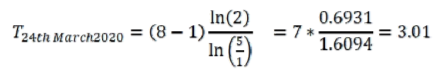

In [ ]:
dfWD['doubleTimeForCases90days']= 90*(np.log(2)/(np.log(dfWD['total_cases']/dfWD['total_cases'].shift(90))))
# dfWD['doubleTimeForCases7']=7/(np.log2(dfWD['total_cases']) - np.log2(dfWD['total_cases'].shift(7)))
dfWD['doubleTimeForCases7days']= 7*(np.log(2)/(np.log(dfWD['total_cases']/dfWD['total_cases'].shift(7))))

In [ ]:
dfWD['doubleTimeForDeaths7days']= 7*(np.log(2)/(np.log(dfWD['total_deaths']/dfWD['total_deaths'].shift(7)))) 
dfWD['doubleTimeForDeaths90days']= 90*(np.log(2)/(np.log(dfWD['total_deaths']/dfWD['total_deaths'].shift(90))))

In [ ]:
dfWD= dfWD.set_index('date')

In [ ]:
dfWDG = dfWD.loc['2020-08-15':'2021-02-23']
dfWDG1 = dfWD.loc['2020-01-27':'2020-08-14']
dfWD['doubleTimeForDeaths']=pd.concat([dfWDG1['doubleTimeForDeaths7days'],dfWDG['doubleTimeForDeaths90days']], axis=0, ignore_index=False)
dfWD['doubleTimeForCases']=pd.concat([dfWDG1['doubleTimeForCases7days'],dfWDG['doubleTimeForCases90days']], axis=0, ignore_index=False)

In [ ]:
dfWD.tail(10)

In [ ]:
dfWD=dfWD.reset_index()

In [ ]:
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Bar(x=dfWD['date'], y=dfWD['total_deaths'], name="Deaths"), secondary_y=False,)
fig2.add_trace(go.Scatter(x=dfWD['date'], y=dfWD['doubleTimeForDeaths'], name="Deaths Doubling Time",marker_color='white'), secondary_y=True,)
fig2.update_xaxes(title_text="Date")
fig2.update_yaxes(title_text="<b>Deaths</b> ", secondary_y=False, tickfont=dict(
            color="#6269f6" ),titlefont=dict(color="#6269f6"))
fig2.update_yaxes(title_text="<b>Doubling Rate (Days)</b> ", secondary_y=True, tickfont=dict(
            color="white" ),titlefont=dict(color="white"))
fig2.update_layout(barmode='overlay', title='How long did it take for the number of total confirmed deaths to double?',hovermode='x',
                template='plotly_dark', width=780,xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='aliceblue'),legend=dict(orientation='h',x=0.1,y=-0.2))
fig2.show()

In [ ]:
# Create figure with secondary y-axis  
fig5 = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
#World: of days to for Cases to double
fig5.add_trace(go.Scatter(x=dfWD['date'], y=dfWD['doubleTimeForCases'], name="Cases Doubling Time"), secondary_y=False,)
fig5.add_trace(go.Scatter(x=dfWD['date'], y=dfWD['doubleTimeForDeaths'], name="Deaths Doubling Time",marker_color='#21bf73'), secondary_y=True,)
fig5.update_layout(title_text="How long did it take for the number of total confirmed deaths and cases to double?")
fig5.update_xaxes(title_text="Date")
fig5.update_yaxes(title_text="<b>Cases Doubling Rate (Days)</b> ", secondary_y=False, tickfont=dict(
            color="#6269f6" ),titlefont=dict(color="#6269f6"))
fig5.update_yaxes(title_text="<b>Deaths Doubling Rate (Days)</b> ", secondary_y=True, tickfont=dict(
            color="#21bf73" ),titlefont=dict(color="#21bf73"))
fig5.update_layout(hovermode='x', width=780, xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='aliceblue'),legend=dict(orientation='h',x=0.1,y=-0.2))
fig5.show()

In [ ]:
dfMMM = cowid1[cowid1['location']=='Turkey']
dfMMM['doubleTimeForDeaths80days']= 80*(np.log(2)/(np.log(dfMMM['total_deaths']/dfMMM['total_deaths'].shift(80))))

In [ ]:
dfMT= dfMMM.set_index('date')
dfMT = dfMT.loc['2020-08-23':'2021-02-23']
dfMT=dfMT.reset_index()

In [ ]:
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Bar(x=dfMT['date'], y=dfMT['total_deaths'], name="Deaths",marker_color='#E30A17'), secondary_y=False,)
fig2.add_trace(go.Scatter(x=dfMT['date'], y=dfMT['doubleTimeForDeaths80days'], name="Deaths Doubling Time",marker_color='white'), secondary_y=True,)
fig2.update_xaxes(title_text="Date")
fig2.update_yaxes(title_text="<b>Deaths</b> ", secondary_y=False, tickfont=dict(
            color="#E30A17" ),titlefont=dict(color="#E30A17"))
fig2.update_yaxes(title_text="<b>Doubling Rate (Days)</b> ", secondary_y=True, tickfont=dict(
            color="white" ),titlefont=dict(color="white"))
fig2.update_layout(barmode='overlay', title='How long did it take for the number of total confirmed deaths to double in Turkey?',hovermode='x',
                template='plotly_dark', width=780,xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='aliceblue'),legend=dict(orientation='h',x=0.1,y=-0.2))
fig2.show()

In [ ]:
"""
def dfM(countries, df, y1):
    df_all = pd.DataFrame(columns=['doubleTimeForDeaths80days'])
    for eachCountry in countries:
        d[eachCountry]  = df[df['location']== countries[eachCountry]]
        d[eachCountry]['doubleTimeForDeaths80days']= 80*(np.log(2)/(np.log(d[eachCountry][y1]/d[eachCountry][y1].shift(80))))
        df_all = df_all.append(d[eachCountry], ignore_index=True)
    return df_all """
"""
def DFM(x):
    x['doubleTimeForDeaths80days']= 80*(np.log(2)/(np.log(x['total_deaths']/x['total_deaths'].shift(80))))
    
  for i in range(len(countries)):
    DFM(countries[i])   
    """

In [ ]:
dfUS = cowid1[cowid1['location']=='United States']
dfITY=cowid1[cowid1['location']=='Italy']
dfUK=cowid1[cowid1['location']=='United Kingdom']
dfSP=cowid1[cowid1['location']=='Spain']
dfFC=cowid1[cowid1['location']=='France']
dfJP=cowid1[cowid1['location']=='Japan']
countries = [ dfUS, dfITY,dfUK,dfSP,dfFC,dfJP]

In [ ]:
for i in range(len(countries)):
    countries[i]['doubleTimeForDeaths80days']= 80*(np.log(2)/(np.log(countries[i]['total_deaths']/countries[i]['total_deaths'].shift(80))))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfUS['date'], y=dfUS['doubleTimeForDeaths80days'],mode='lines',name='Unites States',line=dict(color='#7339D7', width=2)))
fig.add_trace(go.Scatter(name='Japan',x=dfJP['date'],y=dfJP['doubleTimeForDeaths80days'],mode='lines',line=dict(color='#F47983', width=1.7)))
fig.add_trace(go.Scatter(name='Turkey',x=dfMMM['date'],y=dfMMM['doubleTimeForDeaths80days'],mode='lines',line=dict(color='#FFFFFF', width=1.7)))
fig.add_trace(go.Scatter(name='Italy',x=dfITY['date'],y=dfITY['doubleTimeForDeaths80days'],mode='lines',line=dict(color='#008C45', width=1.7)))
fig.add_trace(go.Scatter(name='France',x=dfFC['date'],y=dfFC['doubleTimeForDeaths80days'],mode='lines',line=dict(color='#318CE7', width=1.7)))
fig.add_trace(go.Scatter(name='World',x=dfWD['date'],y=dfWD['doubleTimeForDeaths'],mode='lines',line=dict(color='#F1BF00', width=1.7)))
fig.add_trace(go.Scatter(name='United Kingdom',x=dfUK['date'],y=dfUK['doubleTimeForDeaths80days'],mode='lines',line=dict(color='#cd0f25', width=1.7)))
fig.update_layout(hovermode='x', title='How many days until the number of deaths double? (Last 4 Months)',xaxis=dict(linewidth=1,linecolor='white',showgrid=False),
                 yaxis=dict(linewidth=1,linecolor='aliceblue'))
start_date = "2020-11-09"
end_date = "2021-02-23"
fig.update_xaxes(type="date", range=[start_date, end_date])
fig.update_yaxes(range=[0, 300])
fig.show()

In [ ]:
dfITLY= dfITY.set_index('date')
dfITLY = dfITLY.loc['2020-06-23':'2021-02-23']
dfITLY=dfITLY.reset_index()

In [ ]:
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
fig2.add_trace(go.Bar(x=dfITLY['date'], y=dfITLY['total_deaths'], name="Deaths",marker_color='#008C45'), secondary_y=False,)
fig2.add_trace(go.Scatter(x=dfITLY['date'], y=dfITLY['doubleTimeForDeaths80days'], name="Deaths Doubling Time",marker_color='white'), secondary_y=True,)
fig2.update_xaxes(title_text="Date")
fig2.update_yaxes(title_text="<b>Deaths</b> ", secondary_y=False, tickfont=dict(
            color="#008C45" ),titlefont=dict(color="#008C45"))
fig2.update_yaxes(title_text="<b>Doubling Rate (Days)</b> ", secondary_y=True, tickfont=dict(
            color="white" ),titlefont=dict(color="white"))
fig2.update_layout(barmode='overlay', title='How long did it take for the number of total confirmed deaths to double in Italy?',hovermode='x',
                template='plotly_dark', width=780,xaxis=dict(mirror=True,linewidth=1,linecolor='white',showgrid=False),
                 yaxis=dict(mirror=True,linewidth=1,linecolor='aliceblue'),legend=dict(orientation='h',x=0.1,y=-0.2))
fig2.show()

<a id = "21"></a><br>
 > Thank you for reading my kernel. I hope, we will be completely back to our usual daily life as soon as possible and we'll see better days.

**Betül Sena Çağlar**

**Contact:**
**[LinkedIn](https://www.linkedin.com/in/betül-sena-çağlar-783307188)**